# 中華英雄_隨機森林
以隨機森林分析玩家各遊戲特徵與本周是否會儲值之關係

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit,cross_validate, StratifiedKFold

from pdpbox import pdp, get_dataset, info_plots
import shap

######################################     讀檔      ####################################################

# 選定資料及時間
lastweak = '2018-10-08'
time = '2018-10-14'
rfm_data = 'CG_RFMmodelExample_20181015_ZH.txt'


# 資料欄位命名
rfm_columns = ['Game','ID','TimeKey','RFM number','RFM','Value index',
#                          時間Key     RFM數字     RFM     價值指數    
    'First deposit date','Last deposit date','Mean interval of deposit date','Mean section of deposit date',
#     第一次儲值日期        最後一次儲值日期           平均儲值日期間隔                    平均儲值日期區間 
    'Number of deposit','Mean of deposit value','Mean section of deposit value',
#     儲值次數              平均儲值金額                 平均儲值金額區間
    'Sum of deposit value','Sum section of deposit value','Last online time',
#     累積儲值金額            累積儲值金額區間                 最後上線時間
    'Level','Occupation','Balance','God beasts','Mounts','Fashions','Complete sets']
#   角色等級   角色職業      殘點      神獸數量   坐騎數量   時裝套裝數量   成套數量


# 讀檔
rfm_zh = pd.read_table(rfm_data, encoding='utf8', names=rfm_columns)



######################################    資料整理    ####################################################


#去除重複帳號
rfm_zh1 = rfm_zh.drop_duplicates('ID', keep='last')

# 處理時間資料
rfm_zh1['TimeKey'] = pd.to_datetime(rfm_zh1['TimeKey'])
rfm_zh1['First deposit date'] = pd.to_datetime(rfm_zh1['First deposit date'])
rfm_zh1['Last deposit date'] = pd.to_datetime(rfm_zh1['Last deposit date'])
rfm_zh1['Last online time'] = pd.to_datetime(rfm_zh1['Last online time'])

# 將時間訂在時間Key
rfm_zh1 = rfm_zh1.loc[(rfm_zh1['TimeKey'] == time)]

# 去除特徵遺失值資料
rfm_zh1 = rfm_zh1.dropna(subset = ['Level','Occupation','God beasts','Mounts','Fashions','Complete sets'])

# 衍伸資料行：上次上線距今天數
rfm_zh1['Last online time'] = rfm_zh1['Last online time'].dt.date
rfm_zh1['TimeKey'] = rfm_zh1['TimeKey'].dt.date
rfm_zh1['Offline'] = rfm_zh1['TimeKey'] - rfm_zh1['Last online time'] + timedelta(days=1)
rfm_zh1['Offline'] = rfm_zh1['Offline'].dt.days

# 創建目標：本周是否有儲值
rfm_zh1['isvalue'] = 0
rfm_zh1.loc[rfm_zh1['Last deposit date'] >= lastweak ,'isvalue'] = 1

# 將職業做One-hot-encoding
rfm_zh2 = pd.get_dummies(rfm_zh1, columns=['Occupation'])

# 將職業欄位中文重新命名為英文
rfm_zh2.rename(columns = {'Occupation_刀皇        ':'Occupation_1',
                          'Occupation_劍仙        ':'Occupation_2',
                          'Occupation_劍聖        ':'Occupation_3',
                          'Occupation_影俠        ':'Occupation_4',
                          'Occupation_棍王        ':'Occupation_5',
                          'Occupation_槍神        ':'Occupation_6',
                          'Occupation_武宗        ':'Occupation_7',
                          'Occupation_毒宗        ':'Occupation_8',
                          'Occupation_腿霸        ':'Occupation_9',
                          'Occupation_血族        ':'Occupation_10'},inplace=True)

# 整理
rfm_zh2 = rfm_zh2[['Level','God beasts', 'Mounts', 'Fashions', 'Complete sets',
                   'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
                   'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8',
                   'Occupation_9', 'Occupation_10', 'Offline', 'isvalue']]


########################################     建立模型     ################################################


# 建立訓練資料與測試資料
x = rfm_zh2.drop(['isvalue'], axis=1)
y = rfm_zh2['isvalue']
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 87, test_size=0.2)

# 隨機森林
rf = RandomForestClassifier(n_estimators=1000)

# 交叉驗證
rf.fit(train_x,train_y)
kfold = StratifiedKFold(n_splits=10,random_state=0)
cross_val_score(rf, train_x, train_y, scoring = "accuracy", cv = kfold ).mean()

# 訓練模型對於test資料的準確率
all_pred_label = rf.predict(test_x)
accuracy_score(test_y,all_pred_label)


# fit
rf.fit(x, y)

A=87

### SHAP

SHAP可以看出每一位玩家怎麼被隨機森林歸類為本周有儲值或沒有儲值的  

>* X軸為每位玩家的特徵資料以及特徵對於模型判斷的貢獻；促使預測為**有儲值**的特徵以**綠色**顯示，促使預測為**沒有儲值**的特徵以**橘色**顯示。
>  
>* Y軸為預測準確率

In [2]:
# SHAP
data = x
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(data)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data, plot_cmap =["#008000", "#ff8800"])  

下圖則是以分布圖呈現整體資料特徵與它們影響模型的關係。  

>* X軸代表影響模型輸出的影響力，離0越遠越有影響力。越左邊代表模型會把它分類到不會儲值；越右邊代表模型會把它分類到會儲值。
>* 顏色代表該資料的值的大小。

值得注意的是：本周當玩家為**10號職業–血族**時，模型偏向將它判斷為不會儲值，這和其他職業有明顯差別


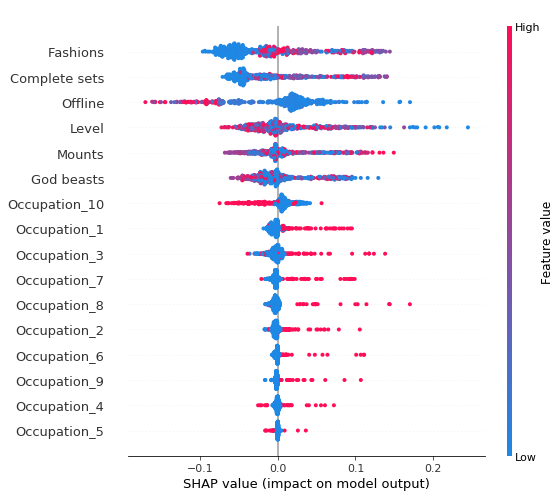

In [3]:
# SHAP summary_plot
shap.summary_plot(shap_values[1], data)

### PDP
PDP可以看出模型中特徵對於目標變量的影響性為何，可以進一步分析重要的特徵。  
> * Y軸離0越遠越能影響模型判斷。

以下圖為例：模型認為**角色等級約200等以前**，對於判定為會儲值有較大的影響力；**角色等級約800等之後**，對於判定為不會儲值有較大的影響力。

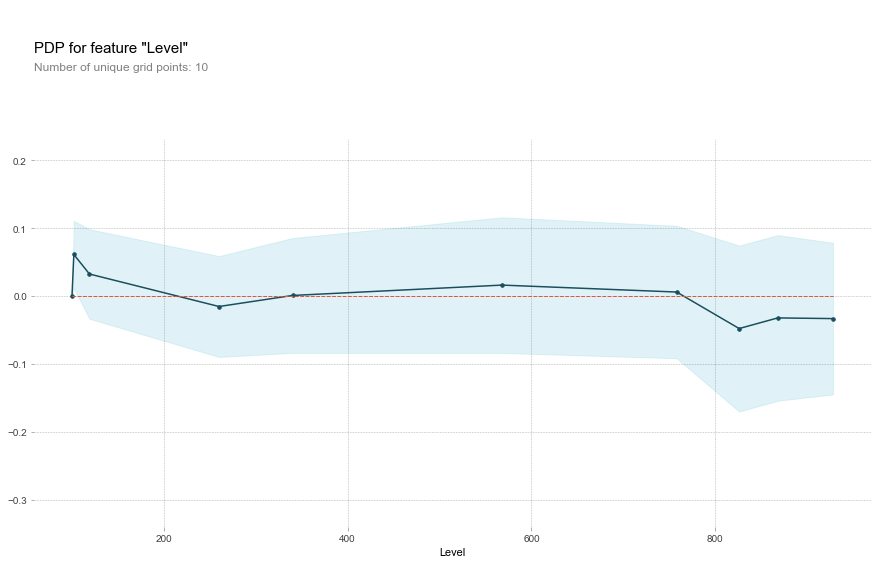

In [4]:
# 角色等級 PDP
pdp_goals = pdp.pdp_isolate(model=rf, dataset=test_x, model_features=x.columns, feature='Level')
pdp.pdp_plot(pdp_goals, 'Level')
plt.show()

In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
程式碼已隱藏以便於閱讀，顯示或隱藏程式碼請點擊 <a href="javascript:code_toggle()">這裡</a>.''')